# Amplitude Look-Up Table (LUT) Example

This notebook demonstrates how to use an amplitude Look-Up Table (LUT) to map the output amplitude to required voltages. This is useful for compensating non-linearities in the signal chain, such as:

- DAC non-linearity
- Amplifier response curves
- Cable/transmission line effects

## The Mapping Function

In this example, we use a sine function from 0 to π as our mapping function. This creates a non-linear transformation where:

$$
V_{out} = A \cdot \sin\left(\frac{\pi (V_{in} + 1)}{2}\right)
$$

This maps the input range $[-1, 1]$ through a sine curve, where:
- Input $-1$ → $\sin(0) = 0$
- Input $0$ → $\sin(\pi/2) = 1$ (maximum)
- Input $1$ → $\sin(\pi) = 0$

This type of transformation can be useful when you need to "soften" the output response or compensate for a system that has a similar inverse characteristic.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import broadbean as bb
from broadbean.plotting import plotter

plt.rcParams["figure.figsize"] = (10, 4)

NoTagError: `git describe --long --dirty --always --tags '--match=v*'` could not find a tag


## Creating the LUT

First, let's create and visualize our sine-based LUT mapping function.

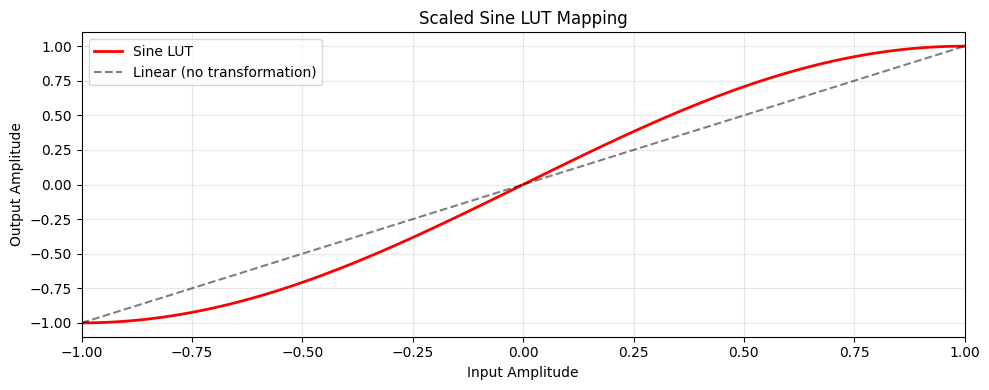

In [22]:
# Create LUT input values (the "x" values)
# These represent the normalized amplitude values from the waveform
n_points = 101  # Number of points in the LUT
lut_input = np.linspace(-1, 1, n_points)

# Create LUT output values using sine function from 0 to pi
# Map input range [-1, 1] to [-pi, pi]
theta = np.pi * lut_input / 2
lut_output = np.sin(theta)

# Visualize the LUT
fig = plt.figure()

# Plot 2: The scaled version
plt.plot(lut_input, lut_output, "r-", linewidth=2, label="Sine LUT")
plt.plot(lut_input, lut_input, "k--", alpha=0.5, label="Linear (no transformation)")
plt.xlabel("Input Amplitude")
plt.ylabel("Output Amplitude")
plt.title("Scaled Sine LUT Mapping")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

## Building a Simple Waveform Sequence

Now let's create a simple sequence with a triangle wave to clearly demonstrate the effect of the LUT transformation.

Original waveform (before LUT):


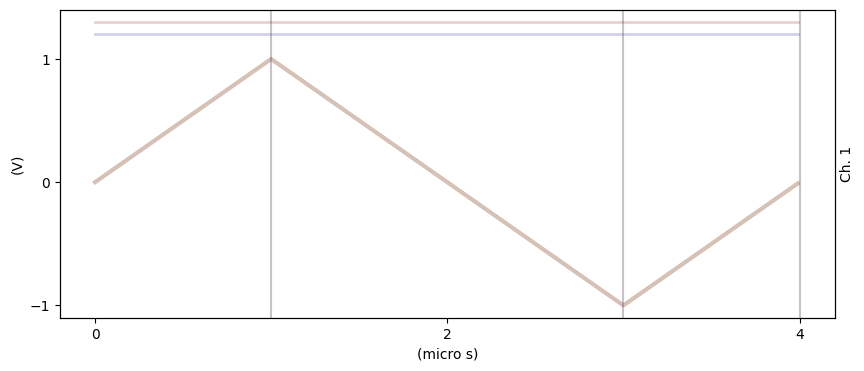

In [23]:
# Get pulse atom functions
ramp = bb.PulseAtoms.ramp

# Create a blueprint with a triangle wave pattern
bp = bb.BluePrint()
bp.setSR(100e6)  # 100 MHz sample rate

# Create triangle wave: ramp up, ramp down, ramp up (negative), ramp down (to zero)
bp.insertSegment(0, ramp, (0, 1), dur=1e-6)  # Ramp from 0 to 1
bp.insertSegment(1, ramp, (1, -1), dur=2e-6)  # Ramp from 1 to -1
bp.insertSegment(2, ramp, (-1, 0), dur=1e-6)  # Ramp from -1 to 0

# Create an element and add the blueprint
elem = bb.Element()
elem.addBluePrint(1, bp)

# Create a sequence
seq = bb.Sequence()
seq.addElement(1, elem)
seq.setSR(1e6)

# Set channel amplitude and offset (required for output generation)
seq.setChannelAmplitude(1, 2.0)  # 2V peak-to-peak
seq.setChannelOffset(1, 0)

# Plot the original sequence
print("Original waveform (before LUT):")
plotter(seq)

## Applying the Amplitude LUT

Now we apply the sine LUT to the sequence. The LUT transformation is applied during the `forge()` method, which processes the waveforms for output.

Waveform with sine LUT applied:


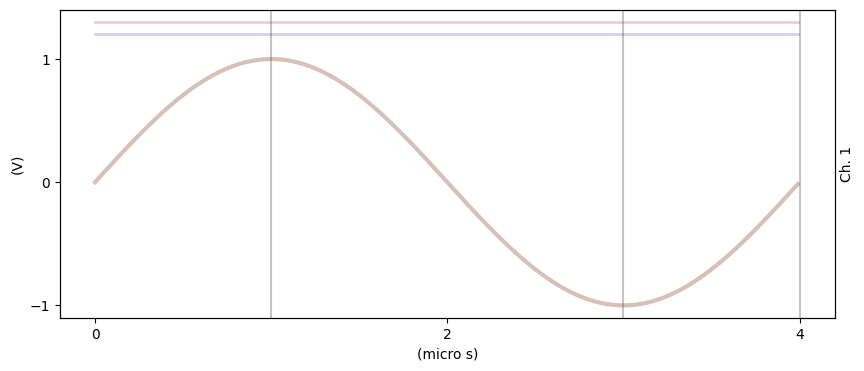

In [24]:
# Create a copy of the sequence to apply the LUT
seq_with_lut = seq.copy()

# Apply the amplitude LUT
# Using the scaled version that maps [-1, 1] -> [-1, 1] through the sine function
seq_with_lut.setAmplitudeLUT(1, list(lut_input), list(lut_output))

print("Waveform with sine LUT applied:")
plotter(seq_with_lut)

## Comparing Before and After

Let's extract the actual waveform data and compare the original vs LUT-transformed signals side by side.

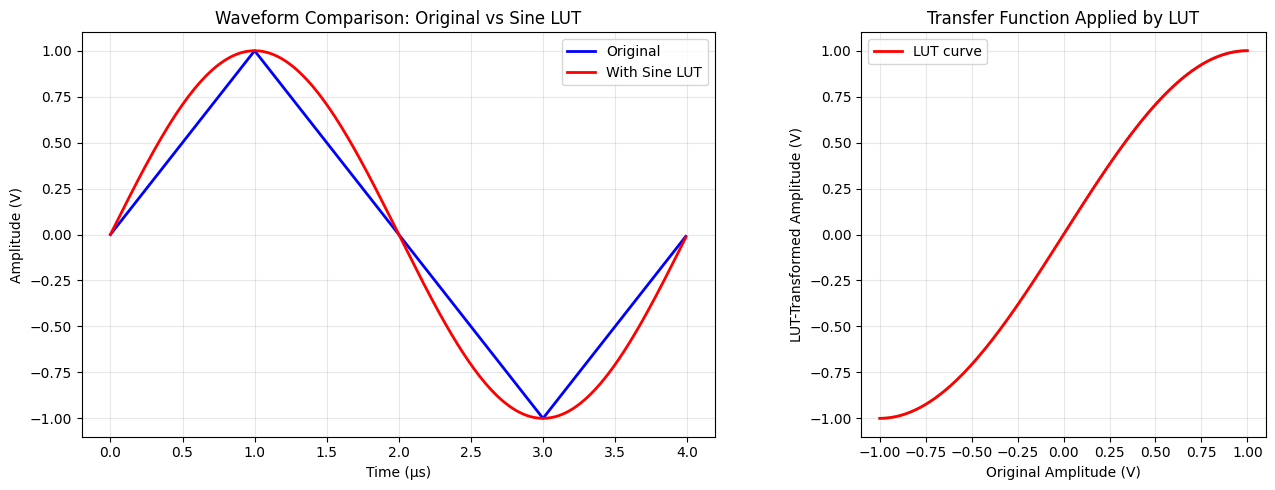

In [25]:
# Forge the sequences to get the actual waveform arrays
forged_original = seq.forge(apply_filters=True, includetime=True)
forged_with_lut = seq_with_lut.forge(apply_filters=True, includetime=True)

# Extract waveform data
wfm_original = forged_original[1]["content"][1]["data"][1]["wfm"]
wfm_with_lut = forged_with_lut[1]["content"][1]["data"][1]["wfm"]
time = forged_original[1]["content"][1]["data"][1]["time"]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time domain comparison
axes[0].plot(time * 1e6, wfm_original, "b-", linewidth=2, label="Original")
axes[0].plot(time * 1e6, wfm_with_lut, "r-", linewidth=2, label="With Sine LUT")
axes[0].set_xlabel("Time (µs)")
axes[0].set_ylabel("Amplitude (V)")
axes[0].set_title("Waveform Comparison: Original vs Sine LUT")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Input vs Output relationship
axes[1].scatter(
    wfm_original, wfm_with_lut, c=time * 1e6, cmap="viridis", s=1, alpha=0.5
)
axes[1].plot(lut_input, lut_output, "r-", linewidth=2, label="LUT curve")
axes[1].set_xlabel("Original Amplitude (V)")
axes[1].set_ylabel("LUT-Transformed Amplitude (V)")
axes[1].set_title("Transfer Function Applied by LUT")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect("equal")

plt.tight_layout()
plt.show()

## Practical Example: Linearizing a Non-Linear Response

A common use case for amplitude LUTs is to compensate for non-linear behavior in the signal chain. For example, if your amplifier has a response that follows $V_{out} = \sin(\frac{\pi V_{in}}{2})$, you would apply the inverse function to pre-distort the signal.

Let's demonstrate this by creating a LUT that would linearize such a response.

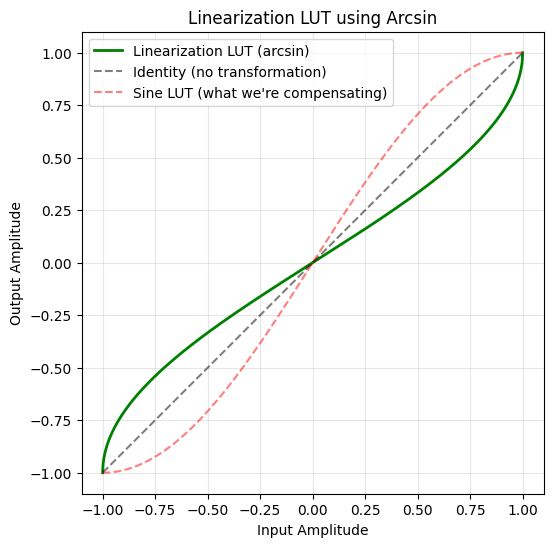


Waveform with linearization LUT (pre-distortion):


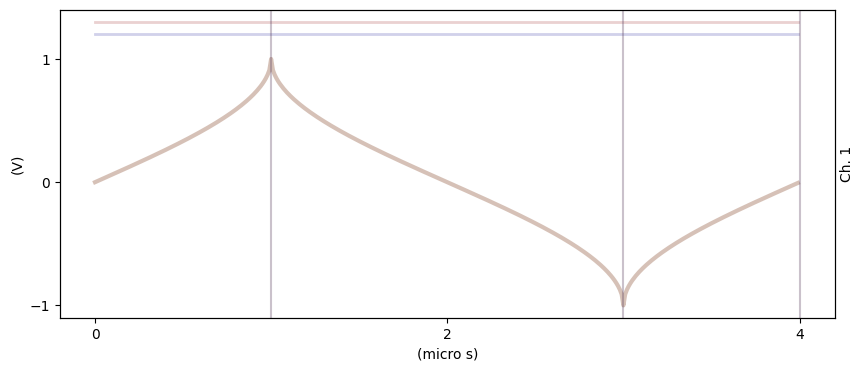

In [26]:
# Suppose the system has a sine-like response
# To compensate, we need the inverse: arcsin

# Create linearization LUT
n_points = 1001
lut_input_linear = np.linspace(-1, 1, n_points)

# The inverse of sin(pi*x/2) is (2/pi)*arcsin(x)
# We need to be careful with the domain of arcsin
lut_output_linear = (2 / np.pi) * np.arcsin(lut_input_linear)

# Create sequence with linearization LUT
seq_linearized = seq.copy()
seq_linearized.setAmplitudeLUT(1, list(lut_input_linear), list(lut_output_linear))

# Visualize the linearization LUT
plt.figure(figsize=(8, 6))
plt.plot(
    lut_input_linear,
    lut_output_linear,
    "g-",
    linewidth=2,
    label="Linearization LUT (arcsin)",
)
plt.plot(
    lut_input_linear,
    lut_input_linear,
    "k--",
    alpha=0.5,
    label="Identity (no transformation)",
)
plt.plot(
    lut_input, lut_output, "r--", alpha=0.5, label="Sine LUT (what we're compensating)"
)
plt.xlabel("Input Amplitude")
plt.ylabel("Output Amplitude")
plt.title("Linearization LUT using Arcsin")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
plt.show()

print("\nWaveform with linearization LUT (pre-distortion):")
plotter(seq_linearized)

## Summary

This notebook demonstrated how to:

1. **Create an amplitude LUT** using a sine function mapping from 0 to π
2. **Apply the LUT** to a sequence using `seq.setAmplitudeLUT(channel, lut_input, lut_output)`
3. **Visualize the effect** of the LUT on waveforms
4. **Use inverse functions** (like arcsin) to linearize non-linear system responses

### Key Points

- The LUT uses linear interpolation (`np.interp`) between specified points
- More points in the LUT provide smoother transformations
- The LUT is applied during the `forge()` method, after any filter compensation
- LUTs can be used for various purposes: linearization, compression, custom response shaping